<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/analysis/macroecon_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 참고: https://www.kci.go.kr/kciportal/ci/sereArticleSearch/ciSereArtiOrteView.kci?sereArticleSearchBean.artiId=ART002113508

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast
import json

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:str='20180501', end:str=str(datetime.datetime.now().date().strftime("%Y%m%d")), interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' \
    + start + '&endTime=' + end +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df

In [48]:
s = Stock('KOSPI')
kospi = s.get_price('20000101', '20210201', 'month')
kospi_change = kospi['Close']/kospi['Close'][0]
kospi

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-31,1028.33,1066.18,875.82,943.88,4798379.0
2000-02-29,955.44,991.71,810.53,828.38,5144645.0
2000-03-31,864.78,928.55,820.30,860.94,6536459.0
2000-04-28,866.75,880.41,688.36,725.39,4113517.0
2000-05-31,731.76,778.46,625.14,731.88,4940337.0
...,...,...,...,...,...
2020-09-29,2340.19,2450.53,2267.63,2327.89,19606889.0
2020-10-30,2330.55,2418.89,2266.93,2267.15,15705570.0
2020-11-30,2276.61,2648.66,2267.95,2591.34,24377955.0


In [49]:
# http://ecos.bok.or.kr/jsp/openapi/OpenApiController.jsp?t=guideStatCd&menuGroup=MENU000004&menuCode=MENU000024
api = 'NTD28IR6I6JDKW29OVKJ'

def get_data(code, unit, start_date, end_date, code2):
  url = 'http://ecos.bok.or.kr/api/StatisticSearch/' + api + '/json/kr/1/5000/' + f'{code}/{unit}/{start_date}/{end_date}/{code2}'
  response = requests.get(url)
  if response.status_code == 200:
      try:
          contents = response.text
      except Exception as e:
          print(str(e))
  df = pd.DataFrame(json.loads(contents)['StatisticSearch']['row'])
  df['DATA_VALUE'] = [float(x) for x in df['DATA_VALUE']]
  if unit == 'YY':
    df['TIME'] = [datetime.datetime.strptime(x, '%Y') for x in df['TIME']]
  elif unit == 'QQ':
    df['TIME'] = df['TIME'].astype(str).str[:-1] + (df['TIME'].astype(str).str[-1].astype(int)*3).astype(str)
    df['TIME'] = [datetime.datetime.strptime(x, '%Y%m') for x in df['TIME']]
  else:
    df['TIME'] = [datetime.datetime.strptime(x, '%Y%m') for x in df['TIME']]
  return df

In [55]:
# gdp growth rate
gdp_growth = get_data('901Y001', 'QQ', '200001', '202101', 'AI1AA')
gdp_growth

,UNIT_NAME,STAT_NAME,ITEM_CODE1,STAT_CODE,ITEM_CODE2,ITEM_CODE3,ITEM_NAME1,ITEM_NAME2,DATA_VALUE,ITEM_NAME3,TIME
0,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,1.9,,2000-03-01
1,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,1.3,,2000-06-01
2,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,2.8,,2000-09-01
3,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,-0.3,,2000-12-01
4,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,1.2,,2001-03-01
...,...,...,...,...,...,...,...,...,...,...,...
79,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,1.3,,2019-12-01
80,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,-1.3,,2020-03-01
81,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,-3.2,,2020-06-01
82,%,17.거시경제분석 지표,AI1AA,901Y001,,,경제성장률,,2.2,,2020-09-01


In [51]:
# foreign-exchange reserves
fer = get_data('038Y001', 'MM', '200001', '202101', 'FIFB4')
fer_change = fer['DATA_VALUE']/fer['DATA_VALUE'][0]
fer

,UNIT_NAME,STAT_NAME,ITEM_CODE1,STAT_CODE,ITEM_CODE2,ITEM_CODE3,ITEM_NAME1,ITEM_NAME2,DATA_VALUE,ITEM_NAME3,TIME
0,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,76580519.0,,2000-01-01
1,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,79379080.0,,2000-02-01
2,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,83299048.0,,2000-03-01
3,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,84196399.0,,2000-04-01
4,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,86471266.0,,2000-05-01
...,...,...,...,...,...,...,...,...,...,...,...
248,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,408231994.0,,2020-09-01
249,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,414167853.0,,2020-10-01
250,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,423963271.0,,2020-11-01
251,천달러,8.5.외환보유액,FIFB4,038Y001,,,외환,,430117234.0,,2020-12-01


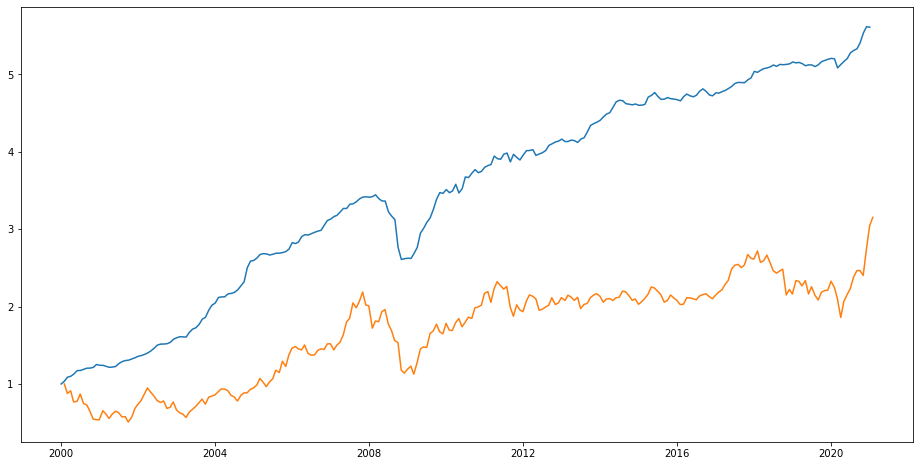

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(fer['TIME'], fer_change)
plt.plot(kospi_change)
plt.show()

In [57]:
# Pearson correlation coefficient
np.corrcoef(fer['DATA_VALUE'], kospi['Close'])[0, 1]

0.9547921824196888

In [64]:
def m2q(df):
  return df[df.index.month%3 == 0]

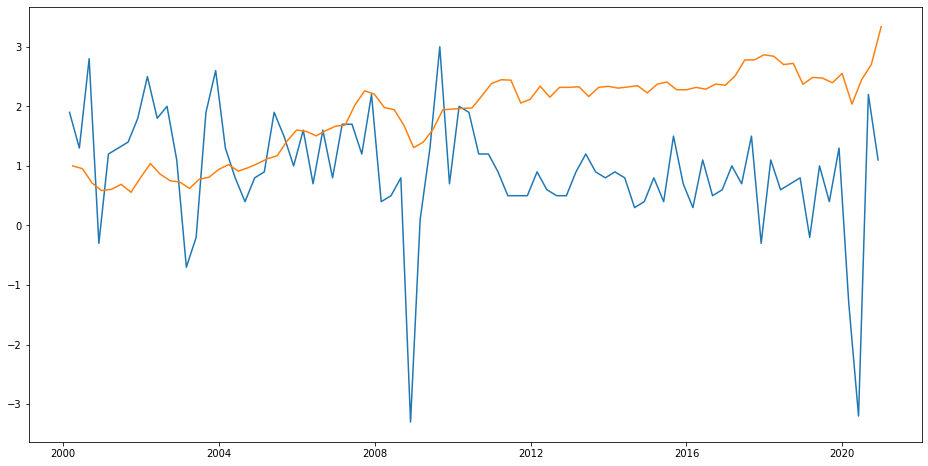

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(gdp_growth['TIME'], gdp_growth['DATA_VALUE'])
plt.plot(m2q(kospi)['Close']/m2q(kospi)['Close'][0])
plt.show()

In [71]:
np.corrcoef(gdp_growth['DATA_VALUE'], m2q(kospi)['Close'])[0, 1]

-0.17072376293182367

In [ ]:
li = [1,4,5,3,2]

In [ ]:
def get_change(li):
  return 